In [1]:
import requests
import json
import pandas as pd
import numpy as np
from functools import reduce
import datetime
import wbdata
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook" # use "pio.renderers" to see the default renderer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Debt forecasting - Testing statistical models
- Goal is to predict debt for next year
- In this notebook I test simple time series models on the World Bank data for a single country
- Adapted from this: https://builtin.com/data-science/time-series-forecasting-python

### Load data

In [3]:
# load data
df = pd.read_csv("debt_data.csv",index_col="date", infer_datetime_format=True, parse_dates=True)

In [4]:
# resample to enforce index frequency
# needed for later steps
# reference to frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
df = df.resample("AS").mean()
# fill NaNs with bfills
df = df.fillna(method="bfill")
# drop cols that only contain NaNs
df = df.dropna(how='all', axis=1)
# drop rows that only contain NaNs
df = df.dropna(how='all', axis=0)
# convert column types from np.float64 to np.int64
df = df.astype(np.int64)
df.head()

,Afghanistan,Angola,Albania,Argentina,Armenia,Azerbaijan,Burundi,Benin,Burkina Faso,Bangladesh,Bulgaria,Bosnia and Herzegovina,Belarus,Belize,Bolivia,Brazil,Bhutan,Botswana,Central African Republic,China,Cote d'Ivoire,Cameroon,"Congo, Dem. Rep.","Congo, Rep.",Colombia,Comoros,Cabo Verde,Costa Rica,Djibouti,Dominica,Dominican Republic,Algeria,Ecuador,"Egypt, Arab Rep.",Eritrea,Ethiopia,Fiji,Gabon,Georgia,Ghana,Guinea,"Gambia, The",Guinea-Bissau,Grenada,Guatemala,Guyana,Honduras,Haiti,Indonesia,India,"Iran, Islamic Rep.",Jamaica,Jordan,Kazakhstan,Kenya,Kyrgyz Republic,Cambodia,Lao PDR,Lebanon,Liberia,St. Lucia,Sri Lanka,Lesotho,Morocco,Moldova,Madagascar,Maldives,Mexico,North Macedonia,Mali,Myanmar,Montenegro,Mongolia,Mozambique,Mauritania,Mauritius,Malawi,Niger,Nigeria,Nicaragua,Nepal,Pakistan,Panama,Peru,Philippines,Papua New Guinea,Paraguay,Romania,Russian Federation,Rwanda,Sudan,Senegal,Solomon Islands,Sierra Leone,El Salvador,Somalia,Serbia,Sao Tome and Principe,Eswatini,Syrian Arab Republic,Chad,Togo,Thailand,Tajikistan,Turkmenistan,Timor-Leste,Tonga,Tunisia,Turkey,Tanzania,Uganda,Ukraine,Uzbekistan,St. Vincent and the Grenadines,Vietnam,Vanuatu,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960-01-01,979344507,7288778066,511485756,5893191433,133922025,35540000,14970400,43206645,20789505,146504255,772737948,2408825764,968283686,4084800,716253874,5984162468,325908,17358400,24142239,5798013609,373548111,145926448,345217589,118823126,2337070268,1172240,39376101,320105203,2594794,14433362,389548000,939559305,402122588,1801624657,29056800,169291507,11665440,103822382,79312483,572138164,336538268,5076000,0,16048000,192905000,82870994,158332049,52164000,3432691278,8425121119,4618942613,981947821,119092816,34977844,477537524,5527412,163589000,8345623,64232860,162259998,15516307,435678442,8122200,984947643,38504010,485146240,8884310,7097271963,1041777825,247329389,163680999,879825840,354767148,1318271500,26315139,31738400,135209089,31677128,836680592,242870748,3800810,3406742576,228889000,3299813044,2196027768,208775480,144131808,30147075,79671384011,4878977,385062510,145252948,11479143,61400031,205547537,73220144,2329427795,2183745,37033600,5388704719,35194310,39801356,1000572108,9731000,276435325,76035317,24548074,603200003,2746453200,197359339,151676389,550691959,59702042,1455000,25579000,3008900,2682000,75993698,48815506,21670999666,813521836,232362560
1961-01-01,979344507,7288778066,511485756,5893191433,133922025,35540000,14970400,43206645,20789505,146504255,772737948,2408825764,968283686,4084800,716253874,5984162468,325908,17358400,24142239,5798013609,373548111,145926448,345217589,118823126,2337070268,1172240,39376101,320105203,2594794,14433362,389548000,939559305,402122588,1801624657,29056800,169291507,11665440,103822382,79312483,572138164,336538268,5076000,0,16048000,192905000,82870994,158332049,52164000,3432691278,8425121119,4618942613,981947821,119092816,34977844,477537524,5527412,163589000,8345623,64232860,162259998,15516307,435678442,8122200,984947643,38504010,485146240,8884310,7097271963,1041777825,247329389,163680999,879825840,354767148,1318271500,26315139,31738400,135209089,31677128,836680592,242870748,3800810,3406742576,228889000,3299813044,2196027768,208775480,144131808,30147075,79671384011,4878977,385062510,145252948,11479143,61400031,205547537,73220144,2329427795,2183745,37033600,5388704719,35194310,39801356,1000572108,9731000,276435325,76035317,24548074,603200003,2746453200,197359339,151676389,550691959,59702042,1455000,25579000,3008900,2682000,75993698,48815506,21670999666,813521836,232362560
1962-01-01,979344507,7288778066,511485756,5893191433,133922025,35540000,14970400,43206645,20789505,146504255,772737948,2408825764,968283686,4084800,716253874,5984162468,325908,17358400,24142239,5798013609,373548111,145926448,345217589,118823126,2337070268,1172240,39376101,320105203,259479

### Setup

In [5]:
sns.set()

In [6]:
country_name = "Armenia"

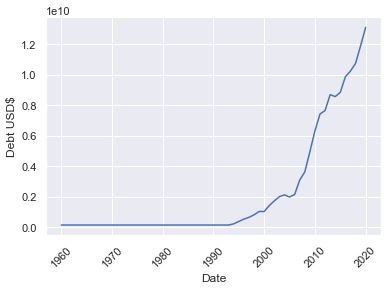

In [7]:
# test plot
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df[country_name])

In [8]:
# train/test split
date_split = pd.to_datetime("2019-01-01", format='%Y-%m-%d')
train = df[country_name][df.index < date_split]
test = df[country_name][df.index >= date_split]

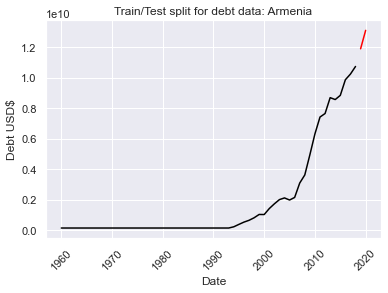

In [9]:
# plot split
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for debt data: "+ country_name)
plt.show()

### ARMA

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
def get_ARMA_preds(country_name, train, test):
    y = train
    ARMAmodel = SARIMAX(y, order = (1, 1, 0))
    ARMAmodel = ARMAmodel.fit()
    
    y_pred = ARMAmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] 

    rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
    #print(country_name, rmse)
    return (rmse, y_pred_out)

In [12]:
arma_preds = get_ARMA_preds(country_name, train, test)

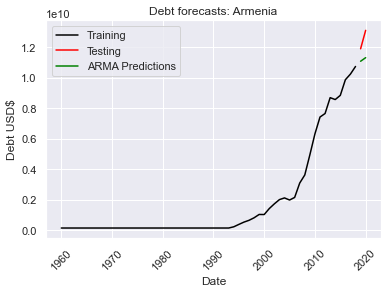

In [24]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(arma_preds[1], color='green', label = 'ARMA Predictions')
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Debt forecasts: "+ country_name)
plt.legend()

### ARIMA

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
def get_ARIMA_preds(country_name, train, test):
    y = train
    ARIMAmodel = ARIMA(y, order = (2, 2, 2))
    ARIMAmodel = ARIMAmodel.fit()
    
    y_pred = ARIMAmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] 

    rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
    #print(country_name, rmse)
    return (rmse, y_pred_out)

In [16]:
arima_preds = get_ARIMA_preds(country_name, train, test)

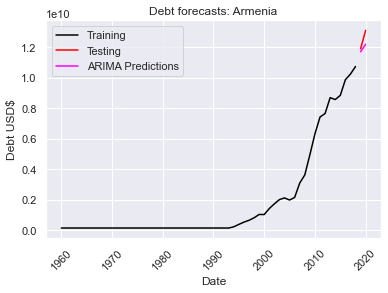

In [23]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(arima_preds[1], color='Magenta', label = 'ARIMA Predictions')
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Debt forecasts: "+ country_name)
plt.legend()

### SARIMA

In [18]:
def get_SARIMA_preds(country_name, train, test):
    y = train
    SARIMAXmodel = SARIMAX(y, order = (1, 1, 0), seasonal_order=(2,2,2,6))
    SARIMAXmodel = SARIMAXmodel.fit()
    
    y_pred = SARIMAXmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] 

    rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
    #print(country_name, rmse)
    return (rmse, y_pred_out)

In [19]:
sarima_preds = get_SARIMA_preds(country_name, train, test)
sarima_preds

/Users/userfriendly/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:996: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/userfriendly/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1008: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



(434537722.4076996,
 date
 2019-01-01    1.249121e+10
 2020-01-01    1.299622e+10
 Freq: AS-JAN, Name: Predictions, dtype: float64)

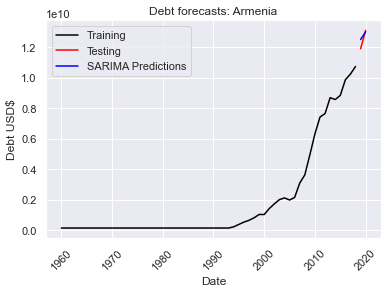

In [22]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(sarima_preds[1], color='Blue', label = 'SARIMA Predictions')
plt.ylabel('Debt USD$')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Debt forecasts: "+ country_name)
plt.legend()